In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import fbeta_score

In [2]:
df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_test = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

In [3]:
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


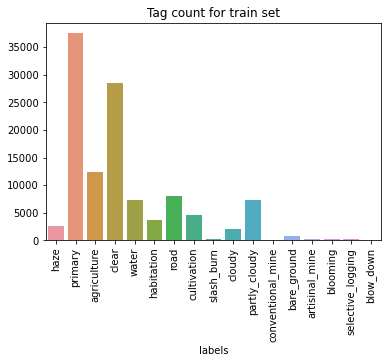

In [7]:
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int) #dictionary containing each individual label
for l in labels:
    for l2 in l:
        counts[l2] += 1
tag_list=list(counts.keys()) 
y=list(counts.values())
sns.barplot(x=tag_list, y=y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag count for train set');


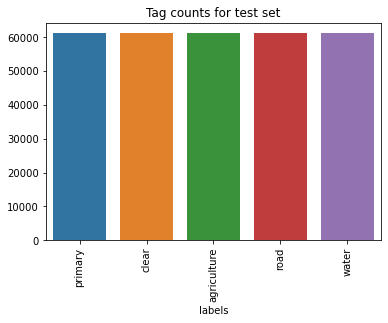

In [8]:
labels_test = df_test['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts_test = defaultdict(int)
for l in labels_test:
    for l2 in l:
        counts_test[l2] += 1

tag_list_test=list(counts_test.keys()) 
test_count=list(counts_test.values())
sns.barplot(x=tag_list_test, y=test_count);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag counts for test set');

In [9]:
label_map = {i:j for j, i in enumerate(tag_list)}
label_map

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

In [10]:
X_train, Y_train = [], []
for img, label in tqdm(df_train.values, miniters = 1000):
  target = np.zeros(17)
  for tag in label.split(' '):
    target[label_map[tag]]=1
  X_train.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
  Y_train.append(target)

100%|██████████| 40479/40479 [02:09<00:00, 313.42it/s]


In [11]:
X_test=[]
for img, label in tqdm(df_test[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))
for img, label in tqdm(df_test[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))

100%|██████████| 20522/20522 [01:09<00:00, 295.19it/s]


In [13]:
x_train = np.array(X_train, np.float16)/255
y_train = np.array(Y_train, np.uint8)
x_test = np.array(X_test, np.float16)/255

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)


In [17]:
import numpy as np
from keras import backend as K


def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop


model = keras.Sequential()
model.add(Conv2D(64, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(17, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = [fbeta])
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, batch_size = 128)

Epoch 1/20
253/253 [==============================] - 3s 11ms/step - loss: 0.2421 - fbeta: 0.6106 - val_loss: 0.2113 - val_fbeta: 0.6527
Epoch 2/20
253/253 [==============================] - 2s 9ms/step - loss: 0.2018 - fbeta: 0.6707 - val_loss: 0.1919 - val_fbeta: 0.7015
Epoch 3/20
253/253 [==============================] - 2s 9ms/step - loss: 0.1890 - fbeta: 0.7011 - val_loss: 0.1861 - val_fbeta: 0.7017
Epoch 4/20
253/253 [==============================] - 2s 8ms/step - loss: 0.1800 - fbeta: 0.7188 - val_loss: 0.1787 - val_fbeta: 0.7482
Epoch 5/20
253/253 [==============================] - 2s 8ms/step - loss: 0.1721 - fbeta: 0.7355 - val_loss: 0.1693 - val_fbeta: 0.7527
Epoch 6/20
253/253 [==============================] - 2s 8ms/step - loss: 0.1666 - fbeta: 0.7461 - val_loss: 0.1675 - val_fbeta: 0.7516
Epoch 7/20
253/253 [==============================] - 2s 9ms/step - loss: 0.1623 - fbeta: 0.7537 - val_loss: 0.1587 - val_fbeta: 0.7602
Epoch 8/20
253/253 [===========================

In [22]:
predictions = model.predict(x_test, batch_size = 128)
result = []
result.append(predictions)

In [ ]:
result= np.array(result[0])
for i in range(1,len(result)):
    result += np.array(result[i])
result= pd.DataFrame(result, columns = labels)
result.head()

In [ ]:
test_classes['tags'] = pred_
test_classes.to_csv('submission_ifeanyi.csv', index = False)